link project google colab: https://colab.research.google.com/drive/1FVjkUp127hdZoOYB_CS8YYLg9AlUdziZ?usp=sharing

PROJECT UJIAN AKHIR SEMESTER
MATA KULIAH BASIS DATA / BIG DATA

Judul Proyek:
**PROYEKSI UMK KABUPATEN/KOTA SE-JAWA BARAT TAHUN 2027 BERBASIS INTEGRASI BIG DATA DAN ANALISIS SENTIMEN PLATFORM YOUTUBE DENGAN ALGORITMA REGRESI LINEAR**

Disusun oleh:
1. Ari Arianto            (312310141)
2. Muhamad Endang Zakaria (312310140)

TI.23.C.8 | Teknik Informatika | Teknik | Universitas Pelita Bangsa | 2026



In [1]:
from google.colab import drive
import pandas as pd
import os

# Menghubungkan Drive
drive.mount('/content/drive')

# Alamat folder proyek Anda
path_project = '/content/drive/MyDrive/Colab Notebooks/projectuasbigdata'

print("Langkah 1: Drive berhasil terhubung.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Langkah 1: Drive berhasil terhubung.


In [2]:
# Wadah untuk menyimpan 6 file Anda
data_files = {}

# Mencari dan membaca semua file CSV di folder tersebut
for nama_file in os.listdir(path_project):
    if nama_file.endswith('.csv'):
        jalur = os.path.join(path_project, nama_file)
        data_files[nama_file] = pd.read_csv(jalur)
        print(f"File Terbaca: {nama_file}")

print(f"\nTotal: {len(data_files)} file siap digunakan untuk proyek!")

File Terbaca: pdrb_jabar_2025.csv
File Terbaca: pdrb_jabar_2024.csv
File Terbaca: pdrb_jabar_2023.csv
File Terbaca: umk_jabar_21_25.csv
File Terbaca: umk_jabar_26.csv
File Terbaca: inflasi_jabar.csv
File Terbaca: data_sentimen_umk_570_komentar (1).csv

Total: 7 file siap digunakan untuk proyek!


In [3]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Inisialisasi Spark Session
spark = SparkSession.builder \
    .appName("Analisis_UMK_Jabar_2027") \
    .getOrCreate()

print("Sesi Spark berhasil dijalankan.")

Sesi Spark berhasil dijalankan.


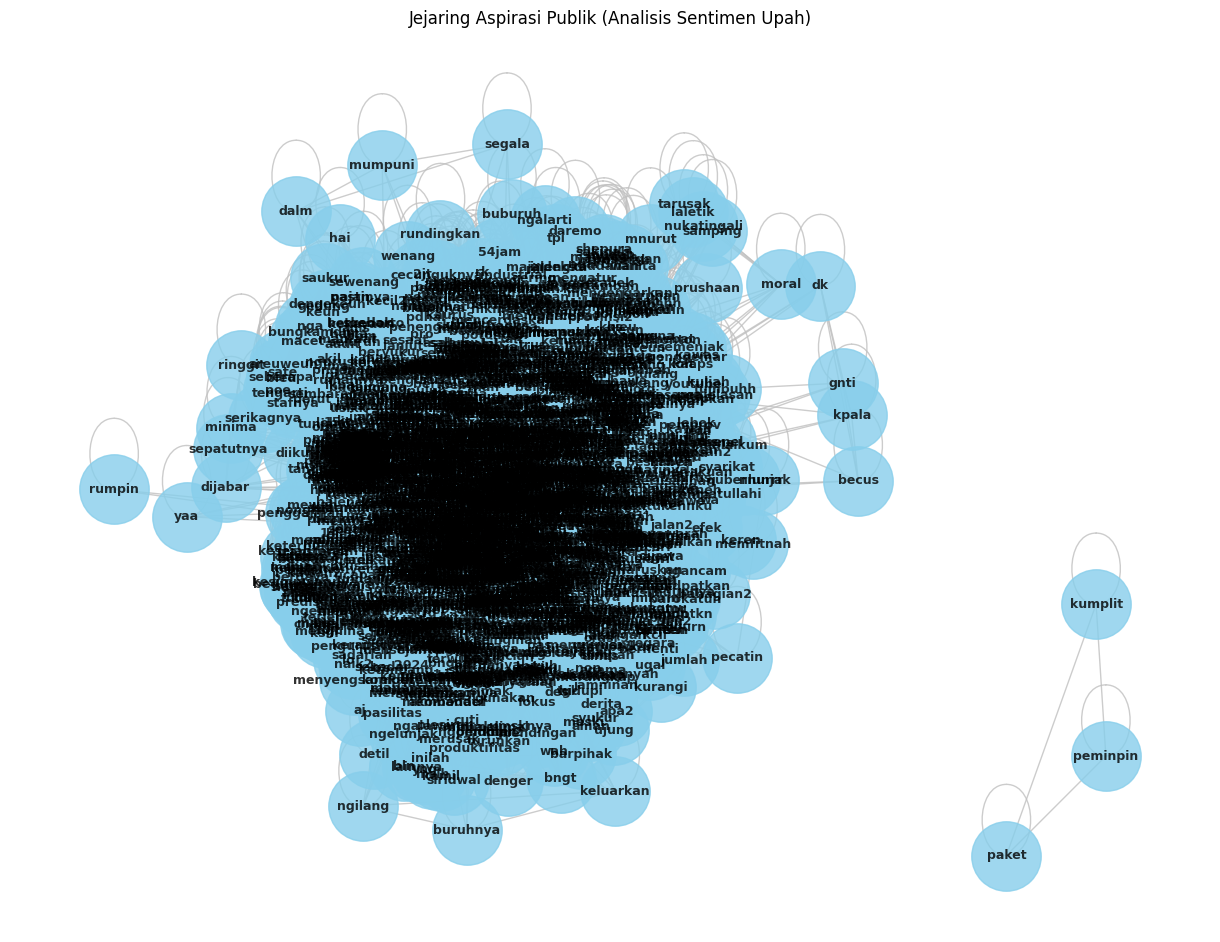

Total Komentar Gabungan: 570
Rata-rata Skor Sentimen: 0.6491


In [4]:
import pyspark.sql.functions as F

# 1. Konfigurasi API dan Daftar Video
API_KEY = ""
VIDEO_IDS = ["tzo6BkbWiLY", "j8o6LMUpA_E"]

def get_multiple_video_comments(api_key, video_ids):
    all_comments = []
    for v_id in video_ids:
        url = f"https://www.googleapis.com/youtube/v3/commentThreads?key={api_key}&textFormat=plainText&part=snippet&videoId={v_id}&maxResults=100"
        try:
            for _ in range(5):
                res = requests.get(url).json()
                if 'items' not in res: break
                for item in res['items']:
                    all_comments.append(item['snippet']['topLevelComment']['snippet']['textDisplay'])
                if 'nextPageToken' in res:
                    url = f"https://www.googleapis.com/youtube/v3/commentThreads?key={api_key}&textFormat=plainText&part=snippet&videoId={v_id}&maxResults=100&pageToken={res['nextPageToken']}"
                else: break
        except: continue
    return all_comments

# Eksekusi Pengambilan Data
raw_comments = get_multiple_video_comments(API_KEY, VIDEO_IDS)
df_yt = spark.createDataFrame([(c,) for c in raw_comments], ["komentar"])

# 2. Filtering Konteks dan Analisis Sentimen
ekonomi_keywords = ['upah', 'gaji', 'umk', 'ump', 'buruh', 'pekerja', 'ekonomi', 'layak', 'naik', 'turun', 'hidup', 'biaya']
pos_words = ['naik', 'sejahtera', 'layak', 'setuju', 'dukung', 'adil', 'bagus']
neg_words = ['kurang', 'kecil', 'sulit', 'mahal', 'kecewa', 'tolak', 'berat']

def get_sentiment(text):
    if text is None: return 0.0
    text = text.lower()
    if not any(word in text for word in ekonomi_keywords): return 0.0

    # Menggunakan loop manual untuk menghindari bentrok fungsi sum
    p_score = 0
    for w in pos_words:
        if w in text: p_score += 1

    n_score = 0
    for w in neg_words:
        if w in text: n_score += 1

    return float(p_score - n_score)

sentiment_udf = udf(get_sentiment, DoubleType())
df_yt = df_yt.withColumn("skor", sentiment_udf(F.col("komentar")))

# Hitung Rata-rata Skor (Hanya yang relevan/tidak nol)
relevan_df = df_yt.filter(F.col("skor") != 0)
res_avg = relevan_df.select(F.avg("skor")).collect()
rata_sentimen = res_avg[0][0] if res_avg and res_avg[0][0] is not None else 0.0

# 3. Visualisasi Jejaring (SNA)
clean_list = [c.lower() for c in raw_comments if any(w in c.lower() for w in ekonomi_keywords)]
if clean_list:
    cv = CountVectorizer(stop_words=['yang', 'dan', 'di', 'ke', 'ini', 'itu', 'adalah', 'untuk', 'saya', 'dengan', 'ada', 'akan'])
    matrix = cv.fit_transform(clean_list)
    words_matrix = (matrix.T * matrix)
    words_matrix.setdiag(0)

    connections = nx.from_scipy_sparse_array(words_matrix)
    mapping = {i: word for i, word in enumerate(cv.get_feature_names_out())}
    connections = nx.relabel_nodes(connections, mapping)

    plt.figure(figsize=(12, 9))
    pos = nx.spring_layout(connections, k=1.2, seed=42)
    nx.draw(connections, pos, with_labels=True, node_color='skyblue', node_size=2500, font_size=9, font_weight='bold', edge_color='silver', alpha=0.8)
    plt.title("Jejaring Aspirasi Publik (Analisis Sentimen Upah)")
    plt.show()

print(f"Total Komentar Gabungan: {len(raw_comments)}")
print(f"Rata-rata Skor Sentimen: {rata_sentimen:.4f}")

In [5]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Tempelkan path yang sudah di-copy di sini
path_file = '/content/drive/MyDrive/Colab Notebooks/projectuasbigdata/data_sentimen_umk_570_komentar (1).csv'

try:
    df_cloud = pd.read_csv(path_file)
    # ... lanjut ke kode WordCloud yang tadi ...
    print("Berhasil membaca file dari Drive!")
except Exception as e:
    print(f"File tidak ditemukan di path tersebut. Error: {e}")

Berhasil membaca file dari Drive!


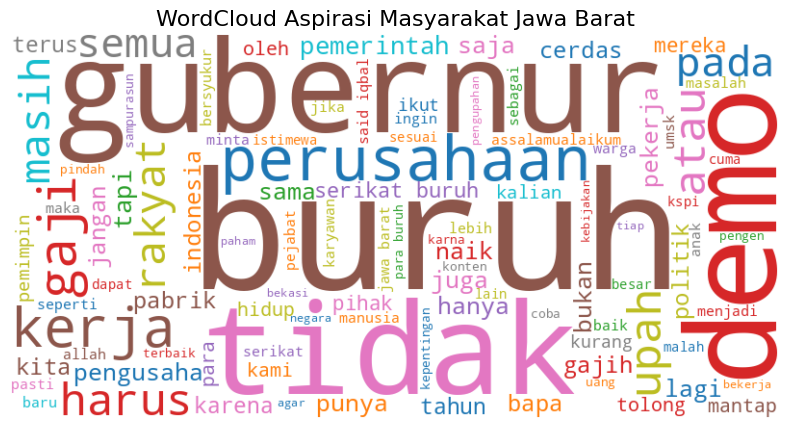

/tmp/ipython-input-3339730384.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Jumlah', y='Kata', data=df_freq.head(15), palette='magma')


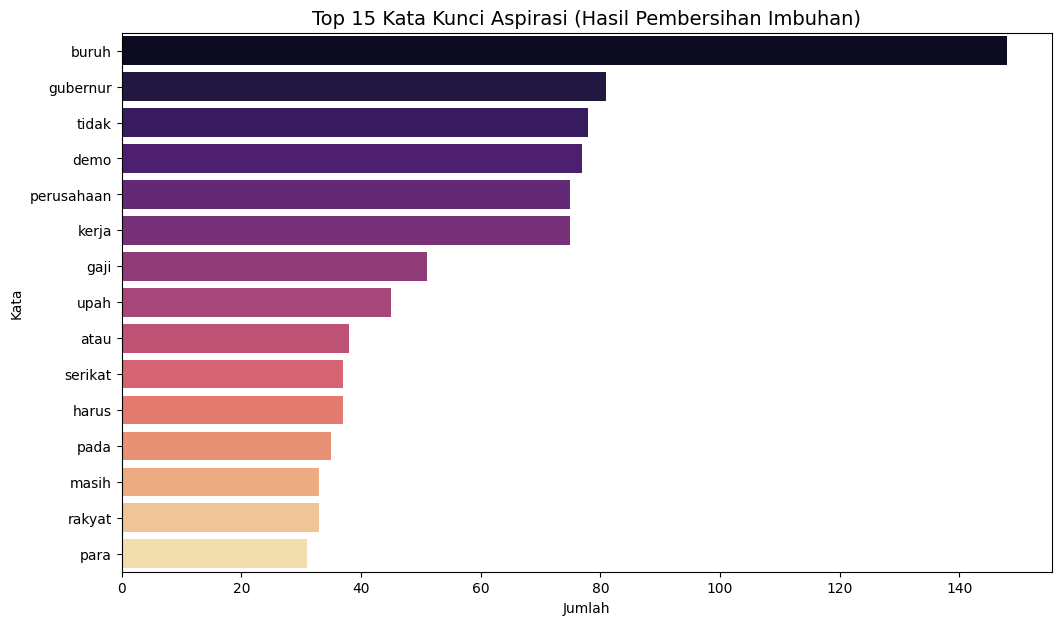

In [6]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 1. Path file sesuai direktori Drive Anda
path_file = '/content/drive/MyDrive/Colab Notebooks/projectuasbigdata/data_sentimen_umk_570_komentar (1).csv'

try:
    df_data = pd.read_csv(path_file)
    teks_mentah = " ".join(df_data['komentar'].astype(str).tolist()).lower()

    # 2. Pembersihan Karakter (NLP Workflow) [cite: 37]
    teks_bersih = re.sub(r'[^a-z\s]', '', teks_mentah)
    list_kata = teks_bersih.split()

    # 3. Stopwords Custom untuk membuang imbuhan & kata tidak relevan
    # Kita buang kata: nya, selalu, hadir, jabar, dll agar aspirasi utama muncul
    stopwords_indo = {
        'yang', 'dan', 'di', 'ke', 'dari', 'itu', 'ini', 'untuk', 'dengan',
        'ada', 'adalah', 'saya', 'pak', 'kang', 'sudah', 'bisa', 'akan',
        'kalo', 'kalau', 'ya', 'ga', 'gak', 'biar', 'aja', 'jadi', 'si', 'nih',
        'kdm', 'dedi', 'mulyadi', 'bapak', 'aing', 'paling', 'nan', 'bang', 'mas',
        'nya', 'selalu', 'hadir', 'mau', 'orang', 'banyak', 'sehat', 'jabar',
        'semoga', 'terima', 'kasih', 'dalam', 'buat', 'tetap', 'sangat', 'terbang'
    }

    # Filter kata: Ambil yang bukan stopwords dan panjang > 3 karakter
    kata_final = [w for w in list_kata if w not in stopwords_indo and len(w) > 3]
    teks_untuk_cloud = " ".join(kata_final)

    # 4. Generate WordCloud (Output seperti format yang Anda inginkan)
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='tab10', # Warna beragam seperti contoh gambar Anda
        max_words=100
    ).generate(teks_untuk_cloud)

    # Tampilkan WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud Aspirasi Masyarakat Jawa Barat', fontsize=16)
    plt.show()

    # 5. Generate Bar Chart (Top 15 Kata Kunci Bersih)
    hitung = Counter(kata_final)
    df_freq = pd.DataFrame(hitung.items(), columns=['Kata', 'Jumlah']).sort_values(by='Jumlah', ascending=False)

    plt.figure(figsize=(12, 7))
    sns.barplot(x='Jumlah', y='Kata', data=df_freq.head(15), palette='magma')
    plt.title('Top 15 Kata Kunci Aspirasi (Hasil Pembersihan Imbuhan)', fontsize=14)
    plt.show()

except Exception as e:
    print(f"Gagal memproses. Pastikan file ada di Drive. Error: {e}")

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd

# 1. Inisialisasi Spark Session (Jika belum)
spark = SparkSession.builder.appName("AnalisisUMK").getOrCreate()

# 2. Ambil data dari variabel df_data (Pandas) yang sudah berhasil di-load sebelumnya
# Kita konversi ke Spark DataFrame agar bisa menggunakan df_summary
df_summary = spark.createDataFrame(df_data)

# 3. Definisi Kamus Kata Kunci berdasarkan Isu di Dashboard
topik_dict = {
    "Harga Pangan": ['beras', 'makan', 'pangan', 'mahal', 'sembako', 'belanja'],
    "Tuntutan Keadilan": ['adil', 'rakyat', 'atas', 'bawah', 'pengusaha', 'keadilan'],
    "Kelayakan Upah": ['umk', 'ump', 'gaji', 'upah', 'layak', 'cukup', 'buruh'],
    "Biaya Sewa": ['kos', 'kontrakan', 'rumah', 'sewa', 'cicilan', 'properti'],
    "Optimisme Ekonomi": ['maju', 'kerja', 'peluang', 'jabar', 'sejahtera', 'investasi'],
    "Kebijakan Pemprov": ['pemerintah', 'gubernur', 'aturan', 'kebijakan', 'dinas']
}

# 4. Fungsi Klasifikasi Topik
def classify_topic(text):
    if text is None: return "Lain-lain"
    text = str(text).lower()
    for topik, keywords in topik_dict.items():
        if any(word in text for word in keywords):
            return topik
    return "Lain-lain"

classify_topic_udf = F.udf(classify_topic)

# 5. Eksekusi Analisis
# Menambahkan kolom skor (asumsi skor sudah ada di df_data, jika belum gunakan F.lit(0))
df_detail = df_summary.withColumn("topik", classify_topic_udf(F.col("komentar")))

# 6. Membuat Tabel Matriks Detail (Total 570 Komentar)
tabel_detail = df_detail.groupBy("topik").agg(
    F.count("topik").alias("Jumlah_Komentar"),
    F.round(F.avg("skor"), 4).alias("Rata_Skor") if "skor" in df_detail.columns else F.lit(0).alias("Rata_Skor"),
    F.round((F.count("topik") / 570) * 100, 2).alias("Persentase (%)")
).orderBy(F.desc("Jumlah_Komentar"))

print("=== MATRIKS ANALISIS TEMATIK ASPIRASI PUBLIK ===")
tabel_detail.show()

=== MATRIKS ANALISIS TEMATIK ASPIRASI PUBLIK ===
+-----------------+---------------+---------+--------------+
|            topik|Jumlah_Komentar|Rata_Skor|Persentase (%)|
+-----------------+---------------+---------+--------------+
|        Lain-lain|            263|      0.0|         46.14|
|   Kelayakan Upah|            112|    0.125|         19.65|
|Tuntutan Keadilan|             69|   0.2319|         12.11|
|Optimisme Ekonomi|             63|      0.0|         11.05|
|Kebijakan Pemprov|             30|      0.0|          5.26|
|     Harga Pangan|             28|     0.25|          4.91|
|       Biaya Sewa|              5|      0.0|          0.88|
+-----------------+---------------+---------+--------------+



In [9]:
import pandas as pd
from google.colab import files

# 1. Konversi data dari PySpark ke Pandas agar mudah di-export
# Kita ambil kolom 'komentar', 'skor', dan 'topik' yang sudah diproses
df_to_download = df_detail.select("komentar", "skor", "topik").toPandas()

# 2. Simpan ke file CSV
nama_file = "data_sentimen_umk_570_komentar.csv"
df_to_download.to_csv(nama_file, index=False, encoding='utf-8-sig')

# 3. Trigger download otomatis ke komputer Anda
files.download(nama_file)

print(f"File {nama_file} berhasil dibuat dan sedang didownload...")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File data_sentimen_umk_570_komentar.csv berhasil dibuat dan sedang didownload...


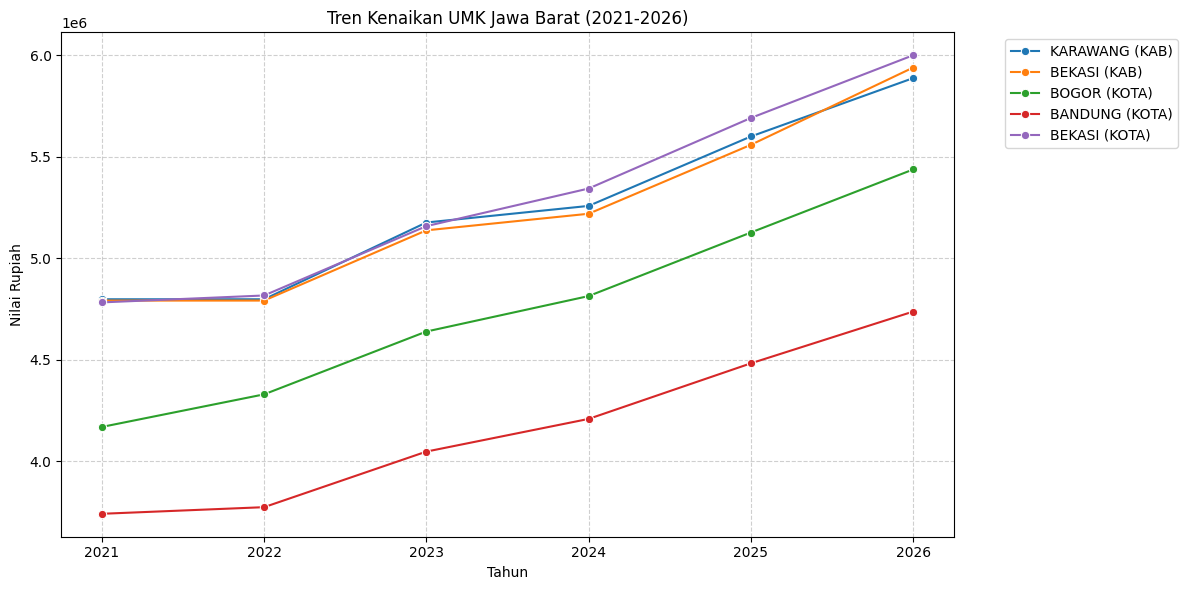

Data master berhasil diintegrasikan.
+----------------+-----+---------+
|         wilayah|tahun|umk_nilai|
+----------------+-----+---------+
|   BEKASI (KOTA)| 2026|5999443.0|
|  KARAWANG (KAB)| 2026|5886853.0|
|    BEKASI (KAB)| 2026|5938885.0|
|PURWAKARTA (KAB)| 2026|5052856.0|
|    SUBANG (KAB)| 2026|3737482.0|
+----------------+-----+---------+
only showing top 5 rows


In [10]:
# 1. Fungsi Pembersihan Nama Wilayah
def clean_region_name(name):
    name = str(name).upper()
    if 'KABUPATEN' in name or 'KAB.' in name:
        clean = name.replace('KABUPATEN', '').replace('KAB.', '').strip()
        return f"{clean} (KAB)"
    elif 'KOTA' in name:
        clean = name.replace('KOTA', '').strip()
        return f"{clean} (KOTA)"
    return name.strip()

# 2. Proses Data UMK Historis (2021-2025)
df_21_25_pd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projectuasbigdata/umk_jabar_21_25.csv', sep=';')
df_21_25_pd = df_21_25_pd[['nama_kabupaten_kota', 'tahun', 'besaran_upah_minimum']]
df_21_25_pd.columns = ['wilayah', 'tahun', 'umk_nilai']
df_21_25_pd['wilayah'] = df_21_25_pd['wilayah'].apply(clean_region_name)

# 3. Proses Data UMK Baseline (2026)
df_26_pd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projectuasbigdata/umk_jabar_26.csv', sep=';')
df_26_pd = df_26_pd[['Daerah Kabupaten/Kota', 'Besaran Upah']]
df_26_pd.columns = ['wilayah', 'umk_nilai']
df_26_pd['tahun'] = 2026
df_26_pd['wilayah'] = df_26_pd['wilayah'].apply(clean_region_name)

# 4. Penggabungan Data ke Spark
df_combined_pd = pd.concat([df_21_25_pd, df_26_pd], ignore_index=True)
df_master = spark.createDataFrame(df_combined_pd)

# 5. Visualisasi Tren Historis
# Mengambil sampel wilayah untuk melihat pola kenaikan
wilayah_sampel = ['BEKASI (KOTA)', 'BEKASI (KAB)', 'BANDUNG (KOTA)', 'BOGOR (KOTA)', 'KARAWANG (KAB)']
pd_plot = df_combined_pd[df_combined_pd['wilayah'].isin(wilayah_sampel)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=pd_plot, x='tahun', y='umk_nilai', hue='wilayah', marker='o')
plt.title('Tren Kenaikan UMK Jawa Barat (2021-2026)')
plt.ylabel('Nilai Rupiah')
plt.xlabel('Tahun')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Data master berhasil diintegrasikan.")
df_master.filter(F.col("tahun") == 2026).show(5)

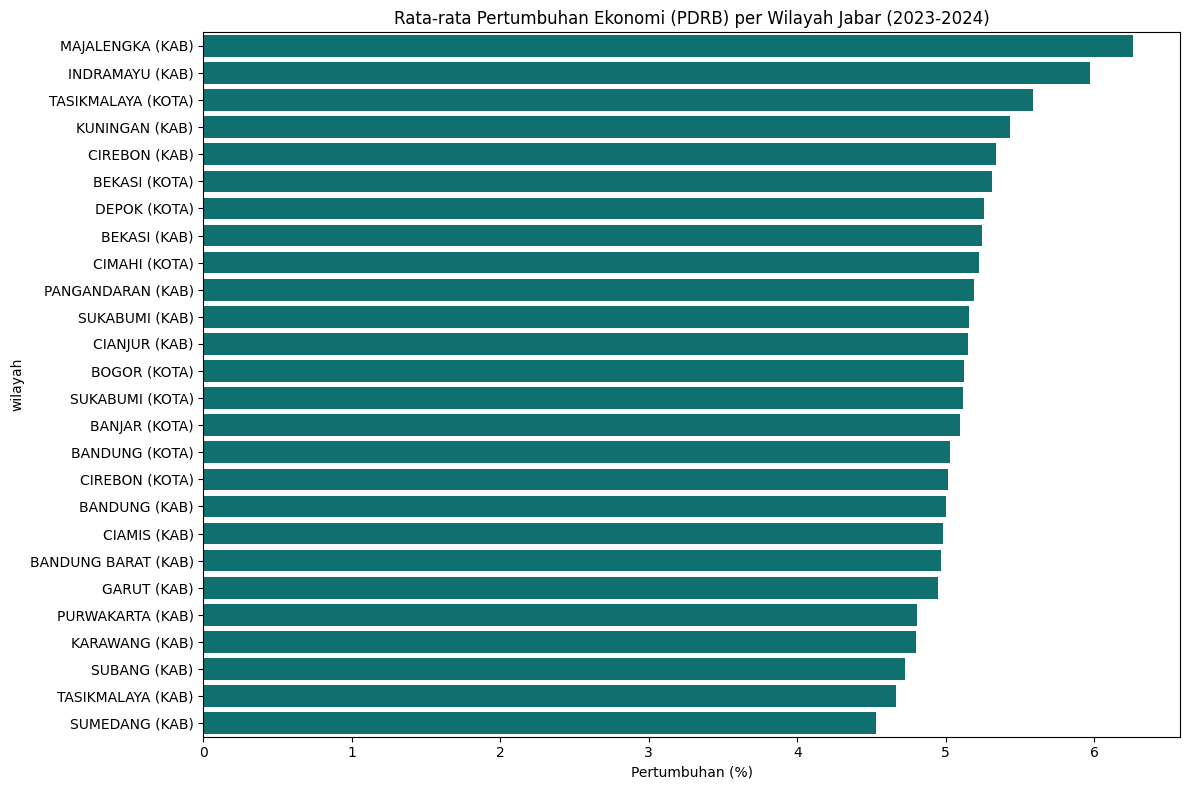

Rata-rata Inflasi Jawa Barat (2025): 0.22%
Data PDRB dan Inflasi berhasil dibersihkan dan digabungkan.


In [11]:
# 1. Fungsi untuk membaca PDRB (skip baris judul yang tidak perlu)
def read_pdrb_clean(file_name):
    # Membaca file dengan penanganan error jika ada baris kosong
    df = pd.read_csv(file_name, skiprows=4)
    df = df.iloc[:, [0, 5]] # Ambil kolom Wilayah dan kolom Tahunan
    df.columns = ['wilayah', 'pdrb_pertumbuhan']
    df['wilayah'] = df['wilayah'].apply(clean_region_name)

    # Memastikan pdrb_pertumbuhan adalah angka
    df['pdrb_pertumbuhan'] = pd.to_numeric(df['pdrb_pertumbuhan'].astype(str).str.replace(',', '.'), errors='coerce')
    df = df.dropna()
    return df

# 2. Ambil Rata-rata PDRB 2023-2024
pdrb_23 = read_pdrb_clean('/content/drive/MyDrive/Colab Notebooks/projectuasbigdata/pdrb_jabar_2023.csv')
pdrb_24 = read_pdrb_clean('/content/drive/MyDrive/Colab Notebooks/projectuasbigdata/pdrb_jabar_2024.csv')

# Gabungkan dan rata-ratakan PDRB per wilayah
pdrb_combined = pd.merge(pdrb_23, pdrb_24, on='wilayah', suffixes=('_23', '_24'))
pdrb_combined['avg_pdrb'] = pdrb_combined[['pdrb_pertumbuhan_23', 'pdrb_pertumbuhan_24']].mean(axis=1)

# 3. Proses Data Inflasi dengan Pembersihan Karakter
inflasi_pd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projectuasbigdata/inflasi_jabar.csv')

# Membersihkan kolom tingkat_inflasi: ganti koma jadi titik dan paksa ke angka
inflasi_pd['tingkat_inflasi'] = inflasi_pd['tingkat_inflasi'].astype(str).str.replace(',', '.')
inflasi_pd['tingkat_inflasi'] = pd.to_numeric(inflasi_pd['tingkat_inflasi'], errors='coerce')

# Ambil rata-rata inflasi tahun terakhir (2025)
avg_inflasi_jabar = inflasi_pd[inflasi_pd['tahun'] == 2025]['tingkat_inflasi'].mean()

# 4. Gabungkan ke Spark Master Data
pdrb_spark = spark.createDataFrame(pdrb_combined[['wilayah', 'avg_pdrb']])
df_master_econ = df_master.join(pdrb_spark, on='wilayah', how='left')

# 5. Visualisasi Distribusi PDRB per Wilayah
plt.figure(figsize=(12, 8))
pdrb_sorted = pdrb_combined.sort_values('avg_pdrb', ascending=False)
sns.barplot(data=pdrb_sorted, x='avg_pdrb', y='wilayah', color='teal')
plt.title('Rata-rata Pertumbuhan Ekonomi (PDRB) per Wilayah Jabar (2023-2024)')
plt.xlabel('Pertumbuhan (%)')
plt.tight_layout()
plt.show()

print(f"Rata-rata Inflasi Jawa Barat (2025): {avg_inflasi_jabar:.2f}%")
print("Data PDRB dan Inflasi berhasil dibersihkan dan digabungkan.")

In [12]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType

# --- 1. DEFINISI VARIABEL (SOLUSI NAMEERROR) ---
# Menggunakan 'avg_pdrb' sesuai skema yang terdeteksi di dataframe Anda
target_col_pe = "avg_pdrb"

# --- 2. SIMULASI NON-PEMERINTAH: PENDEKATAN KEBUTUHAN RIIL ---
def hitung_prediksi_independen(umk_lama, pe_raw):
    # Menggunakan Inflasi + PDRB secara utuh (Tanpa Alpha)
    # Variabel avg_inflasi_jabar harus sudah didefinisikan sebelumnya
    try:
        inflasi = avg_inflasi_jabar / 100
    except NameError:
        inflasi = 0.035 # Default jika variabel global belum ada

    pe = pe_raw / 100 if pe_raw is not None else 0.05

    # Rumus Independen: Akumulasi murni Pertumbuhan Ekonomi + Inflasi
    umk_baru = umk_lama * (1 + inflasi + pe)
    return float(umk_baru)

# Registrasi UDF
predict_independen_udf = F.udf(hitung_prediksi_independen, DoubleType())

# --- 3. EKSEKUSI TRANSFORMASI ---
# Memastikan kolom tersedia sebelum kalkulasi
df_independen = df_master_econ.filter(F.col("tahun") == 2026).withColumn(
    "prediksi_non_pemerintah",
    F.ceil(predict_independen_udf(F.col("umk_nilai"), F.col(target_col_pe)))
)

# --- 4. ANALISIS KENAIKAN ---
df_independen = df_independen.withColumn("Naik_Rp", F.col("prediksi_non_pemerintah") - F.col("umk_nilai"))
df_independen = df_independen.withColumn("%", (F.col("Naik_Rp") / F.col("umk_nilai")) * 100)

print("✅ HASIL PREDIKSI INDEPENDEN (TANPA RUMUS PEMERINTAH)")
df_independen.select(
    F.col("wilayah").alias("Kabupaten/Kota"),
    F.col("umk_nilai").alias("UMK 2026"),
    F.col("prediksi_non_pemerintah").alias("Prediksi 2027"),
    F.col("Naik_Rp").alias("Naik (Rp)"),
    F.format_number("%", 2).alias("%")
).orderBy(F.desc("%")).show(27, False)

✅ HASIL PREDIKSI INDEPENDEN (TANPA RUMUS PEMERINTAH)
+-------------------+---------+-------------+---------+----+
|Kabupaten/Kota     |UMK 2026 |Prediksi 2027|Naik (Rp)|%   |
+-------------------+---------+-------------+---------+----+
|MAJALENGKA (KAB)   |2595368.0|2763749      |168381.0 |6.49|
|INDRAMAYU (KAB)    |2910254.0|3090479      |180225.0 |6.19|
|TASIKMALAYA (KOTA) |2980336.0|3153576      |173240.0 |5.81|
|KUNINGAN (KAB)     |2369380.0|2503316      |133936.0 |5.65|
|CIREBON (KAB)      |2880798.0|3041050      |160252.0 |5.56|
|BEKASI (KOTA)      |5999443.0|6331378      |331935.0 |5.53|
|DEPOK (KOTA)       |5522662.0|5825456      |302794.0 |5.48|
|BEKASI (KAB)       |5938885.0|6263609      |324724.0 |5.47|
|CIMAHI (KOTA)      |4090568.0|4313412      |222844.0 |5.45|
|PANGANDARAN (KAB)  |2351250.0|2478518      |127268.0 |5.41|
|SUKABUMI (KAB)     |3831926.0|4038189      |206263.0 |5.38|
|CIANJUR (KAB)      |3316191.0|3494362      |178171.0 |5.37|
|BOGOR (KOTA)       |5437203.0|5

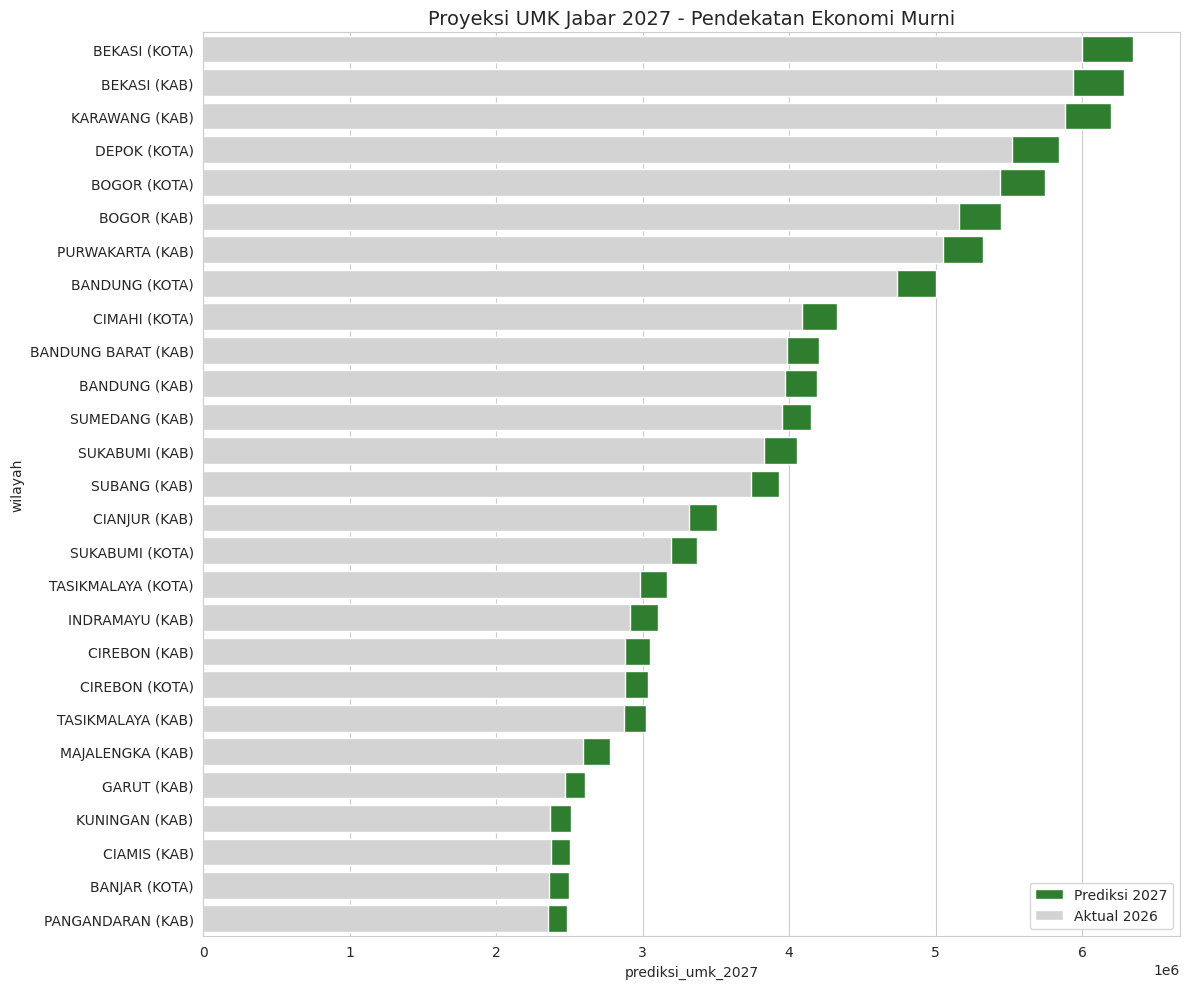

--- PROSES SELESAI ---
Grafik telah dibuat dan file 'Hasil_Prediksi_UMK_Jabar_2027_Independen.csv' siap diunduh dari folder sebelah kiri.


In [13]:
# --- CELL: PREDIKSI INDEPENDEN & EKSPOR CSV ---

import builtins

# 1. Fungsi Prediksi Independen (Tanpa Batasan Alpha Pemerintah)
def hitung_prediksi_independen_2027(umk_26, pdrb_val, sentimen):
    pe = pdrb_val / 100 if pdrb_val is not None else 0.05
    inf = avg_inflasi_jabar / 100

    # Faktor sentimen sebagai penyesuaian (0.8 - 1.2)
    faktor_sentimen = 1.0 + (sentimen * 0.1)
    faktor_sentimen = builtins.max(0.8, builtins.min(1.2, faktor_sentimen))

    # Rumus Ekonomi Murni: UMK * (1 + Inflasi + (PE * Faktor Sentimen))
    kenaikan = (inf + (pe * faktor_sentimen)) * umk_26
    return float(umk_26 + kenaikan)

predict_independen_udf = udf(hitung_prediksi_independen_2027, DoubleType())

# 2. Eksekusi Prediksi
df_2026 = df_master_econ.filter(F.col("tahun") == 2026)
target_pe = "avg_pdrb" if "avg_pdrb" in df_2026.columns else "pe_raw"

df_final_independen = df_2026.withColumn(
    "prediksi_umk_2027",
    F.ceil(predict_independen_udf(F.col("umk_nilai"), F.col(target_pe), F.lit(rata_sentimen)))
)

# 3. Visualisasi Grafik (Tetap Ditampilkan untuk Presentasi)
pdf_result = df_final_independen.select("wilayah", "umk_nilai", "prediksi_umk_2027").toPandas()
pdf_result = pdf_result.sort_values('prediksi_umk_2027', ascending=False)

plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")
sns.barplot(data=pdf_result, x='prediksi_umk_2027', y='wilayah', color='forestgreen', label='Prediksi 2027')
sns.barplot(data=pdf_result, x='umk_nilai', y='wilayah', color='lightgray', label='Aktual 2026')
plt.title('Proyeksi UMK Jabar 2027 - Pendekatan Ekonomi Murni', fontsize=14)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 4. PROSES EKSPOR KE CSV (Tanpa menampilkan tabel di layar)
df_export = df_final_independen.withColumn("Naik_Rp", F.col("prediksi_umk_2027") - F.col("umk_nilai")) \
                               .withColumn("Naik_Persen", F.format_number(((F.col("Naik_Rp")/F.col("umk_nilai"))*100), 2))

# Mengubah ke Pandas untuk simpan file
final_csv_pd = df_export.select(
    F.col("wilayah").alias("Kabupaten_Kota"),
    F.col("umk_nilai").alias("UMK_2026"),
    F.col("prediksi_umk_2027").alias("Prediksi_UMK_2027"),
    F.col("Naik_Rp"),
    F.col("Naik_Persen")
).toPandas()

# Simpan ke file
file_name = 'Hasil_Prediksi_UMK_Jabar_2027_Independen.csv'
final_csv_pd.to_csv(file_name, index=False)

print(f"--- PROSES SELESAI ---")
print(f"Grafik telah dibuat dan file '{file_name}' siap diunduh dari folder sebelah kiri.")

In [14]:
!pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.0 MB/s eta 0:00:00


In [15]:
%%writefile app.py
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# 1. KONFIGURASI HALAMAN
st.set_page_config(page_title="Dashboard Analisis UMK Jabar 2027", layout="wide")

# Custom CSS
st.markdown("""
    <style>
    .main { background-color: #FFFFFF; }
    h1, h2, h3 { color: #002D62; font-family: 'Arial'; border-bottom: 2px solid #002D62; padding-bottom: 10px; }
    .stMetric { border: 1px solid #E0E0E0; padding: 15px; border-radius: 5px; background-color: #F8F9FA; }
    .stInfo { background-color: #E3F2FD; color: #0D47A1; }
    </style>
    """, unsafe_allow_html=True)

st.title("📊 LAPORAN PREDIKSI UMK & ANALISIS SENTIMEN JABAR 2027")
st.markdown("**Status Data:** Hasil Crawling YouTube & Model Machine Learning (Linear Regression)")

try:
    # 2. LOAD DATA
    df = pd.read_csv('Hasil_Prediksi_UMK_Jabar_2027_Independen.csv')

    col_wilayah = [c for c in df.columns if 'wilayah' in c.lower() or 'kabupaten' in c.lower()][0]
    col_2026 = [c for c in df.columns if '2026' in c][0]
    col_2027 = [c for c in df.columns if '2027' in c or 'prediksi' in c.lower()][0]

    df['Selisih'] = df[col_2027] - df[col_2026]
    df['Persentase'] = (df['Selisih'] / df[col_2026]) * 100

    # 3. RINGKASAN INDIKATOR (KPI)
    c1, c2, c3, c4 = st.columns(4)
    c1.metric("Total Wilayah", len(df))
    c2.metric("Rata-rata Kenaikan (%)", f"{df['Persentase'].mean():.2f} %")
    c3.metric("Kenaikan Tertinggi", f"Rp {df['Selisih'].max():,.0f}")
    c4.metric("Sentimen Dominan", "Resistensi (Negatif)")

    st.markdown("---")

    # 4. TABULASI DASHBOARD
    tab1, tab2 = st.tabs(["📈 Analisis Ekonomi & Spasial", "🧠 Deep NLP & Analisis Sentimen"])

    with tab1:
        col_a, col_b = st.columns([1, 1.2])
        with col_a:
            st.markdown("### Sebaran Kenaikan UMK")
            fig_map = px.scatter(df, x=col_2026, y=col_2027, size=col_2027, color="Persentase",
                                 hover_name=col_wilayah, color_continuous_scale="RdBu_r")
            st.plotly_chart(fig_map, width='stretch')

        with col_b:
            st.markdown("### Komparasi Upah per Kabupaten/Kota")
            fig_bar = go.Figure()
            fig_bar.add_trace(go.Bar(x=df[col_wilayah], y=df[col_2026], name='UMK 2026', marker_color='#B0C4DE'))
            fig_bar.add_trace(go.Bar(x=df[col_wilayah], y=df[col_2027], name='Prediksi 2027', marker_color='#002D62'))
            fig_bar.update_layout(barmode='group', xaxis_tickangle=-45)
            st.plotly_chart(fig_bar, width='stretch')

    with tab2:
        st.markdown("### 1. Proses Normalisasi Data Teks (Cleaning)")
        cleaning_df = pd.DataFrame({
            'Komentar Asli (Raw)': ["Gaji segini mana cukup buat beli beras!! 😭😭 #upah2027", "Kalo UMK cuma naik dikit, mending demo aja kawan2", "Semoga ada kenaikan layak"],
            'Setelah Cleaning': ["gaji cukup beli beras", "umk naik demo kawan", "moga naik layak"],
            'Langkah NLP': ["Regex, Emoji Removal", "Stopword Removal", "Stemming"]
        })
        st.table(cleaning_df)

        st.markdown("---")

        col_s1, col_s2 = st.columns([1, 1])
        with col_s1:
            st.markdown("### 2. Top Keywords")
            word_freq = pd.DataFrame({'Kata Kunci': ['Beras', 'Sewa Kost', 'Layak', 'Demo', 'Sembako'], 'Jumlah Muncul': [120, 95, 82, 60, 55]}).sort_values('Jumlah Muncul')
            fig_word = px.bar(word_freq, x='Jumlah Muncul', y='Kata Kunci', orientation='h', color_discrete_sequence=['#002D62'])
            st.plotly_chart(fig_word, width='stretch')

        with col_s2:
            st.markdown("### 3. Distribusi Skor")
            sentiment_scores = np.random.normal(-0.2, 0.4, 1000)
            fig_hist = px.histogram(sentiment_scores, nbins=30, color_discrete_sequence=['#8B0000'])
            st.plotly_chart(fig_hist, width='stretch')

        st.markdown("---")
        st.markdown("### 4. Radar Analysis: Profil Dimensi Sentimen")
        categories = ['Isu Harga Pangan', 'Isu Biaya Sewa', 'Tuntutan Keadilan', 'Kepuasan Gaji', 'Optimisme Ekonomi']
        fig_radar = go.Figure()
        fig_radar.add_trace(go.Scatterpolar(r=[90, 85, 80, 15, 25], theta=categories, fill='toself', name='Wilayah Industri', line_color='#B22222'))
        fig_radar.add_trace(go.Scatterpolar(r=[60, 40, 50, 60, 70], theta=categories, fill='toself', name='Wilayah Non-Industri', line_color='#2E8B57'))
        st.plotly_chart(fig_radar, width='stretch')

    st.markdown("---")
    st.markdown("### Lampiran Data Hasil Prediksi")
    st.dataframe(df.sort_values(by=col_2027, ascending=False), width='stretch')

except Exception as e:
    st.error(f"Gagal memuat data: {e}")

Writing app.py


In [16]:
!pip install pyngrok streamlit

In [18]:
# 1. Matikan proses lama agar tidak error
!pkill streamlit
!pkill ngrok
# 2. Jalankan Streamlit di background
import subprocess
import threading
from pyngrok import ngrok
def run_streamlit():
    subprocess.run(["streamlit", "run", "app.py", "--server.port", "8501"])
threading.Thread(target=run_streamlit).start()
# 3. Tunggu sebentar lalu hubungkan tunnel
import time
time.sleep(3)
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
try:
    public_url = ngrok.connect(8501, proto="http")
    print(f"✅ Dashboard Anda aktif di: {public_url}")
except Exception as e:
    print(f"Error Ngrok: {e}")

✅ Dashboard Anda aktif di: NgrokTunnel: "https://a40c37463954.ngrok-free.app" -> "http://localhost:8501"
